In [104]:
from Kaggle import Kaggle
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img, img_to_array
from keras._tf_keras.keras.applications.efficientnet import EfficientNetB1
from keras._tf_keras.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras as K

import numpy as np
import PIL
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import Image
import imutils
import time


import os, sys, random
from pathlib import Path
from typing import Sequence, Dict
from tqdm.auto import tqdm
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
%matplotlib inline

In [2]:
os.environ['KAGGLE_USERNAME'] = os.getenv(key='kaggle_username',default="Could not find kaggle_username")
os.environ['KAGGLE_KEY'] = os.getenv(key='kaggle_key',default="Could not find kaggle_key")

In [3]:
kaggle_ = Kaggle()

In [4]:
if not os.path.exists('artifacts'):
    os.makedirs('artifacts',exist_ok=True)
kaggle_.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset", data_dir='artifacts', force=False)

Skipping, found downloaded files in "artifacts\brain-tumor-mri-dataset" (use force=True to force download)


In [31]:
# Data visualisation
train_dir = "artifacts/brain-tumor-mri-dataset/Training/"
test_dir = "artifacts/brain-tumor-mri-dataset/Testing/"

In [33]:
classes = os.listdir(train_dir)

In [34]:
# for tumor_name in classes:
#     path = f'./artifacts/crop_brain_mri/{tumor_name}'
#     if not os.path.exists(path):
#         os.makedirs(path,exist_ok=True)

In [38]:
filepath_dict = {}
for c in tqdm(classes):
    filepath_dict[c] = list(map(lambda x : train_dir + c + '/' + x, os.listdir(train_dir + c)))

100%|██████████| 4/4 [00:00<00:00, 255.73it/s]


In [39]:
filepath_test_dict = {}
for c in tqdm(classes):
    filepath_test_dict[c] = list(map(lambda x : test_dir + c + '/' + x, os.listdir(test_dir + c)))

100%|██████████| 4/4 [00:00<00:00, 817.72it/s]


In [42]:
filepath_test_dict.keys()

dict_keys(['glioma', 'meningioma', 'notumor', 'pituitary'])

In [43]:
filepath_dict.keys()

dict_keys(['glioma', 'meningioma', 'notumor', 'pituitary'])

In [44]:
filepath_dict['glioma'][0]

'artifacts/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg'

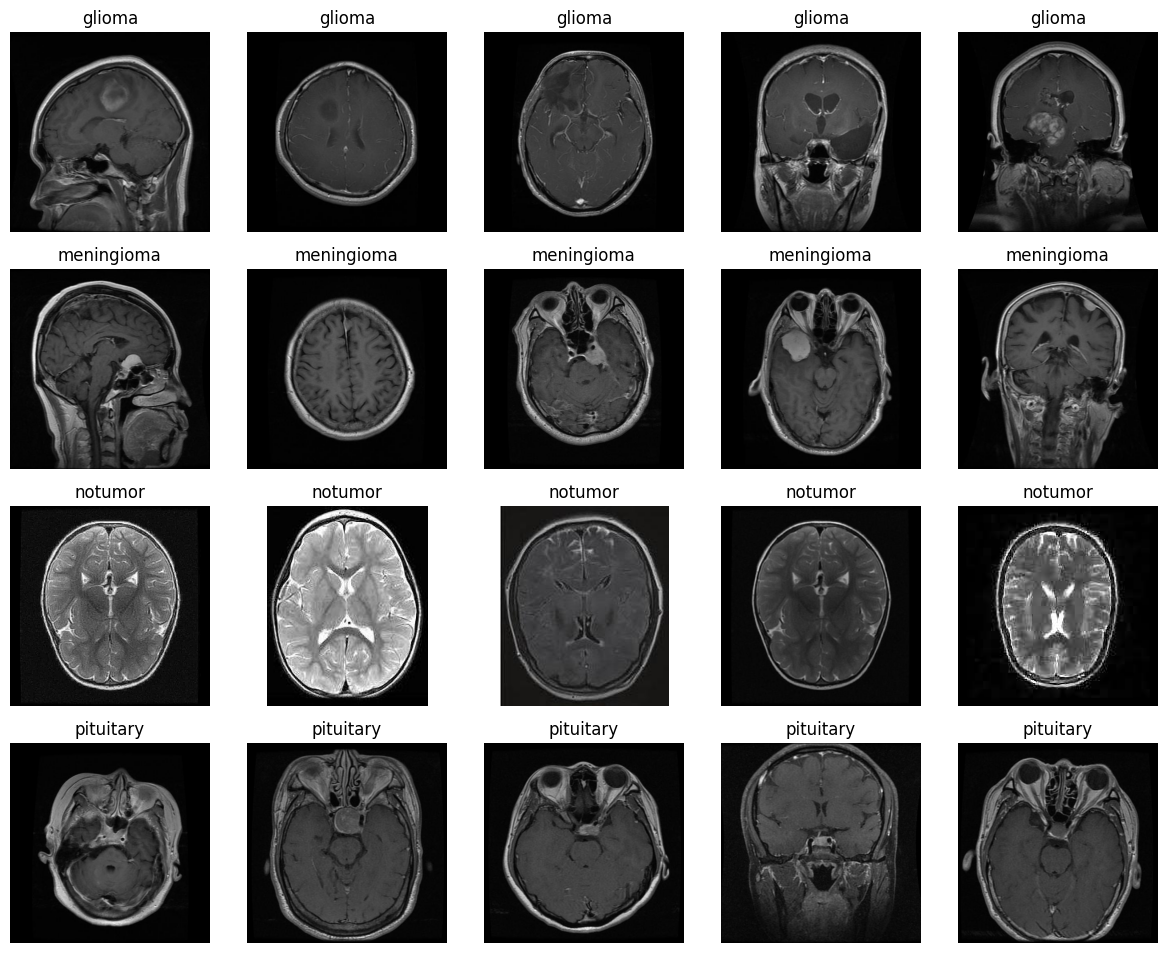

In [45]:
def show_grid(filepath_dict:dict, rows_x_cols:tuple=(4,4), n_images:int=6):
    plt.figure(figsize=(12,12))
    index=0
    for c in classes:
        random.shuffle(filepath_dict[c])
        path_list = filepath_dict[c][:n_images]

        for i in range(1,n_images):
            index+=1
            plt.subplot(*rows_x_cols,index)
            plt.imshow(load_img(path_list[i]))
            plt.title(c)
            plt.axis("off")
            plt.tight_layout()

show_grid(filepath_dict=filepath_dict, rows_x_cols=(5,5), n_images=6)

In [46]:
no_of_images_per_class = []
class_name = []
for i in os.listdir(train_dir):
    train_class = os.listdir(os.path.join(train_dir,i))
    no_of_images_per_class.append(len(train_class))
    class_name.append(i)

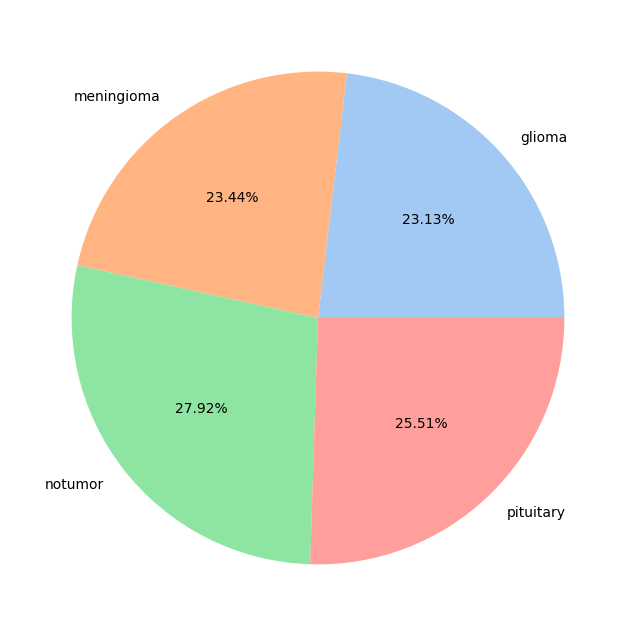

In [47]:
dict(zip(class_name,no_of_images_per_class))

plt.figure(figsize=(8,8))
colors = sns.color_palette('pastel')
plt.pie(x=no_of_images_per_class, labels=class_name, autopct="%1.2f%%", colors=colors)
plt.show()

In [ ]:

class Preprocess_Images:

    @staticmethod
    def crop_image(image:os.PathLike, plot=False):
        try:
            ex_image= cv2.imread(image)
            img_gray = cv2.cvtColor(src=ex_image, code=cv2.COLOR_BGR2GRAY)
            img_blur = cv2.GaussianBlur(src=img_gray, ksize=(5, 5), sigmaX=0, sigmaY=0)
            img_thresh = cv2.threshold(src=img_blur, thresh=45, maxval=255, type=cv2.THRESH_BINARY)[1]
            img_thresh = cv2.erode(src=img_thresh,kernel=None, iterations=2)
            img_thresh = cv2.dilate(src=img_thresh, kernel=None, iterations=2)
            contours = cv2.findContours(image=img_thresh.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
            contours = imutils.grab_contours(contours)
            c = max(contours, key = cv2.contourArea)

            extLeft = tuple(c[c[:, :, 0].argmin()])[0]
            extRight = tuple(c[c[:, :, 0].argmax()])[0]
            extTop = tuple(c[c[:, :, 1].argmin()])[0]
            extBottom = tuple(c[c[:, :, 1].argmax()])[0]

            new_img = ex_image[extTop[1]: extBottom[1], extLeft[0]:extRight[0]]

            if plot:
                plt.figure(figsize = (12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(ex_image)
                plt.title("Original Image")
                plt.subplot(1, 2, 2)
                plt.imshow(new_img)
                plt.title("Cropped Image")
                plt.show()
            return new_img
        except Exception:
            print(Exception(f"Error occured with cropping file {image}"))

    def save_cropped_images(self, classes:Sequence[str],filepath_dict:Dict[str,Sequence[os.PathLike]], save_path_folder:os.PathLike)->None:

        with tqdm(classes, leave=True) as class_:
            for c in class_:
                class_.set_description(desc=c)
                for i,image_path in tqdm(enumerate(filepath_dict[c]), desc=f"{c}-{len(filepath_dict[c])} images",total=len(filepath_dict[c]), leave=True):
                    image_path=os.path.normpath(image_path)
                    cropped_image = self.crop_image(image_path, plot=False)

                    if cropped_image is not None:
                        resized_img = cv2.resize(src=cropped_image,dsize=(240,240))
                        save_path = os.path.join(save_path_folder, c, f"{i}.jpg")
                        if not os.path.exists(save_path):
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                        cv2.imwrite(filename=save_path, img=resized_img)


preprocess_images = Preprocess_Images()
#'artifacts\\brain-tumor-mri-dataset\\Training\\glioma\\Te-glTr_0000.jpg'

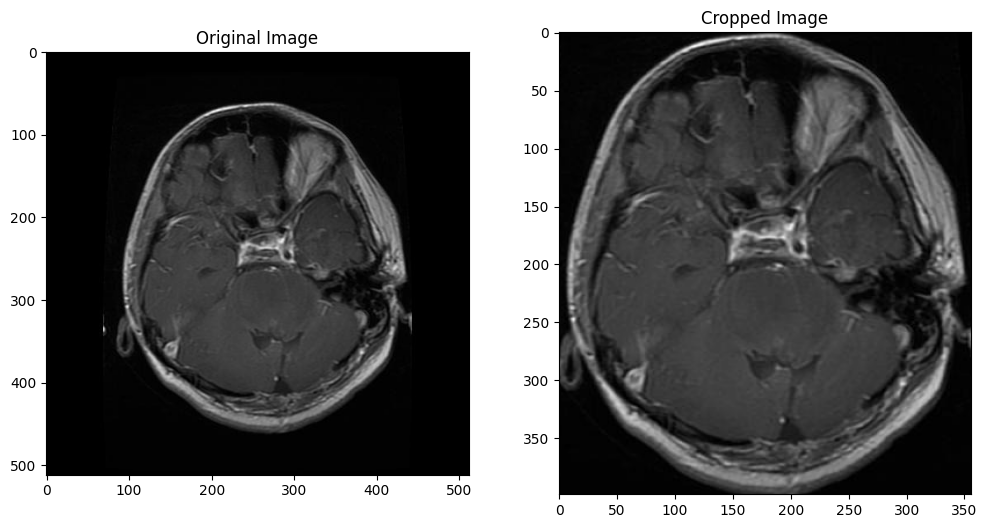

In [50]:
ex_image = r"artifacts\brain-tumor-mri-dataset\Testing\glioma\Te-gl_0010.jpg"
cropped_imgs = preprocess_images.crop_image(image=ex_image, plot=True)

In [ ]:
#save cropped images into crop_brain_mri train and test folders respectively
preprocess_images.save_cropped_images(classes=classes,filepath_dict=filepath_dict,save_path_folder="artifacts/crop_brain_mri/train")
preprocess_images.save_cropped_images(classes=classes,filepath_dict=filepath_test_dict,save_path_folder="artifacts/crop_brain_mri/test")


In [56]:
# Image Augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

In [58]:
train_data = datagen.flow_from_directory(directory="artifacts/crop_brain_mri/train", target_size=(240,240), batch_size=16, class_mode='categorical',subset='training')
val_data = datagen.flow_from_directory(directory="artifacts/crop_brain_mri/train", target_size=(240,240), batch_size=16, class_mode='categorical',subset='validation')
test_datagen = ImageDataGenerator()
test_data = test_datagen.flow_from_directory(directory="artifacts/crop_brain_mri/test",target_size=(240,240),class_mode='categorical',shuffle=False)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


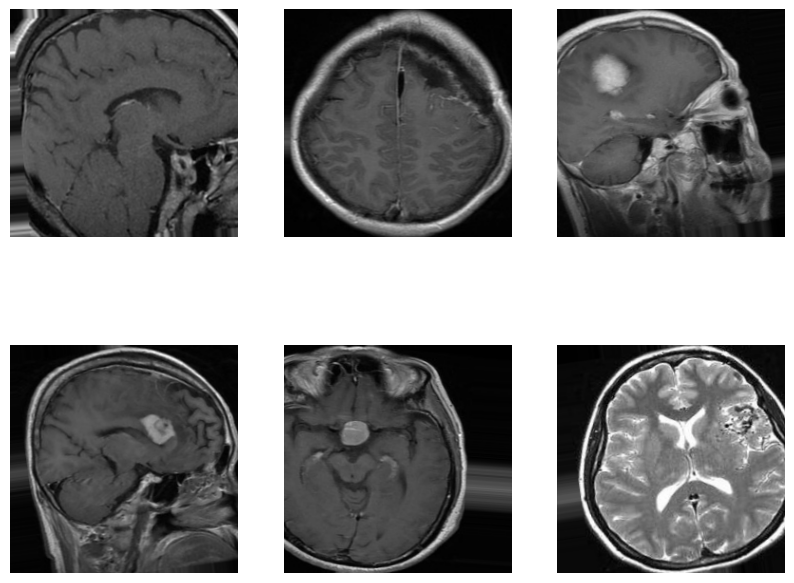

In [65]:
sample_x, sample_y = next(iter(train_data))
plt.figure(figsize=(10,8))

for i in range(6):
    plt.subplot(2,3,i+1)
    sample = array_to_img(sample_x[i])
    plt.axis('off')
    plt.grid('False')
    plt.imshow(sample)
plt.show()

In [70]:
effenet = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(240,240,3))
model = effenet.output
model = K.layers.GlobalAveragePooling2D()(model)
model = K.layers.Dropout(0.5)(model)
model = K.layers.Dense(4, activation="softmax")(model)
model = K.Model(inputs=effenet.input, outputs=model)
model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [74]:
model.compile(
    optimizer=K.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy',save_best_only=True, mode='auto', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [75]:
%%time
history = model.fit(train_data, epochs=30, validation_data=val_data, verbose=1, callbacks=[checkpoint,early_stopping,reduce_lr])

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7150 - loss: 0.7492

c:\Users\ict-tyson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.83699, saving model to model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.7154 - loss: 0.7482 - val_accuracy: 0.8370 - val_loss: 0.4378 - learning_rate: 1.0000e-04
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9459 - loss: 0.1735
Epoch 2: val_accuracy improved from 0.83699 to 0.95881, saving model to model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 832s 3s/step - accuracy: 0.9459 - loss: 0.1735 - val_accuracy: 0.9588 - val_loss: 0.1169 - learning_rate: 1.0000e-04
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9643 - loss: 0.0993
Epoch 3: val_accuracy improved from 0.95881 to 0.96407, saving model to model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 833s 3s/step - accuracy: 0.9643 - loss: 0.0993 - val_accuracy: 0.9641 - val_loss: 0.1095 - learning_rate: 1.0000e-04
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9832 - loss: 0.0595
Epoch 4: val_accuracy improved from 0.96407 to 0.97546, s

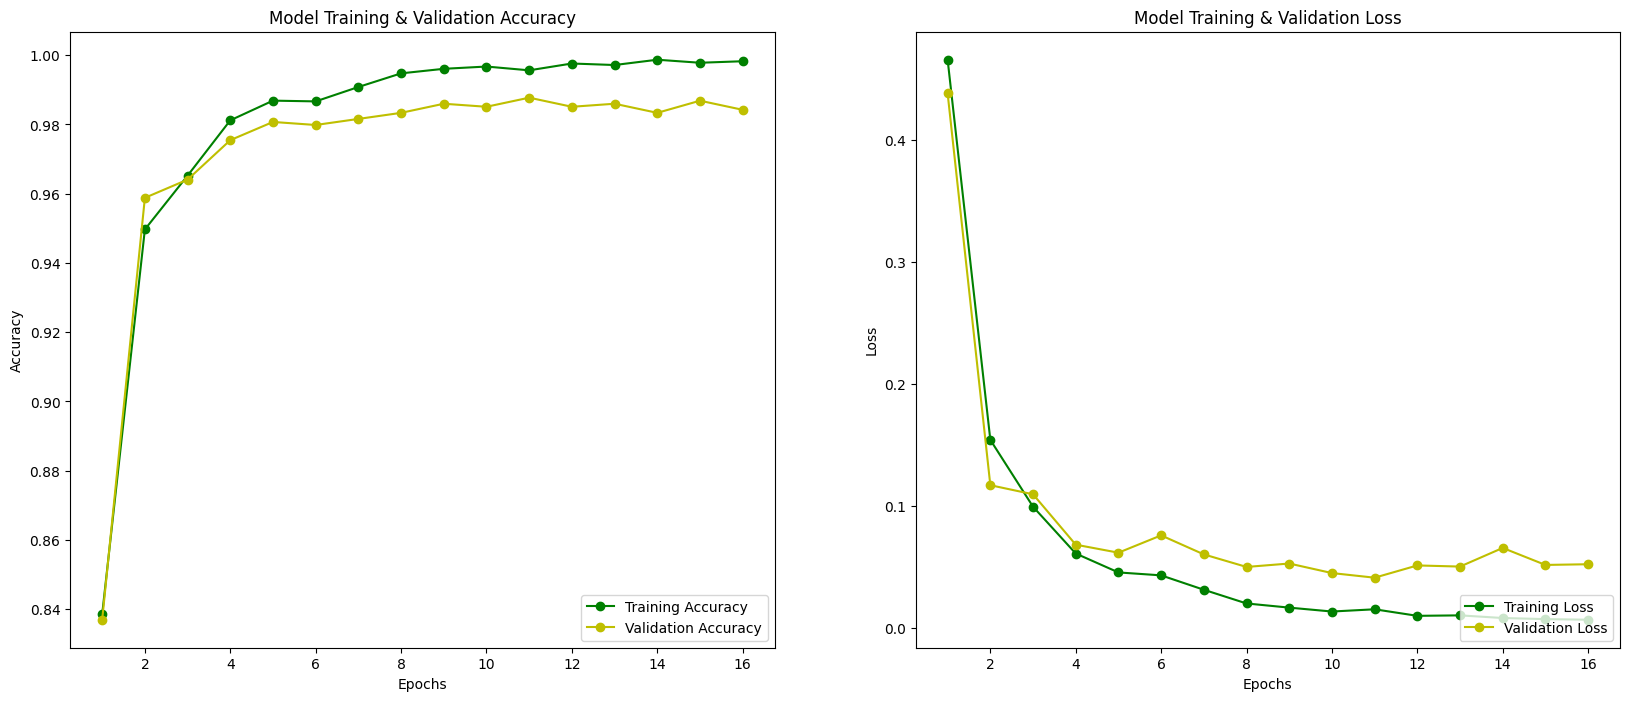

In [84]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,8)
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epoch = range(1,len(train_acc)+1)


ax[0].plot(epoch, train_acc, 'g-o', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'y-o', label='Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epoch, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epoch, val_loss, 'y-o', label='Validation Loss')
ax[1].set_title('Model Training & Validation Loss')
ax[1].legend(loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()


In [85]:
model.evaluate(train_data)

286/286 ━━━━━━━━━━━━━━━━━━━━ 216s 756ms/step - accuracy: 0.9993 - loss: 9.4457e-04


[0.0006339221727102995, 0.9995624423027039]

In [86]:
model.evaluate(test_data)

c:\Users\ict-tyson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9963 - loss: 0.0227


[0.01890561729669571, 0.9954233169555664]

In [87]:
preds = model.predict(test_data)

41/41 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


In [94]:
y_hat = np.argmax(preds,axis=1)
y_test = test_data.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [100]:
cm = confusion_matrix(y_pred=y_hat, y_true=y_test)

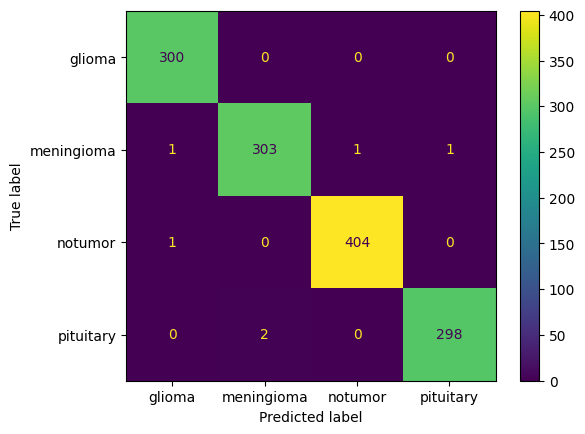

In [101]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= test_data.class_indices.keys())
cm_display.plot()
plt.show()

In [102]:
print(classification_report(y_true=y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       0.99      0.99      0.99       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
# Predict Test images
for class_ in classes:
    print(test_dir+class_)

artifacts/brain-tumor-mri-dataset/Testing/glioma
artifacts/brain-tumor-mri-dataset/Testing/meningioma
artifacts/brain-tumor-mri-dataset/Testing/notumor
artifacts/brain-tumor-mri-dataset/Testing/pituitary


In [ ]:
import PIL.Image


images=[]
predictions=[]
original=[]

for class_, class_value in tqdm(train_data.class_indices.items()):
    image_folder = [os.path.join(test_dir,class_,image) for image in os.listdir(test_dir+class_)]
    for image_path in image_folder:
        image_path = os.path.normpath(image_path)
        img = cv2.imread(image_path)
        img = cv2.resize(src=img, dsize=(240,240))
        images.append(img)
        img = np.expand_dims(img, axis=0)
        preds = model.predict(img, verbose=3)
        preds = np.argmax(preds)
        predictions.append(preds)
        original.append(class_value)

100%|██████████| 4/4 [04:53<00:00, 73.26s/it]


In [155]:
original = [np.int64(train_data.class_indices[class_]) for class_ in original]

In [176]:
score = accuracy_score(original, predictions)
round(score*100,2)

98.86

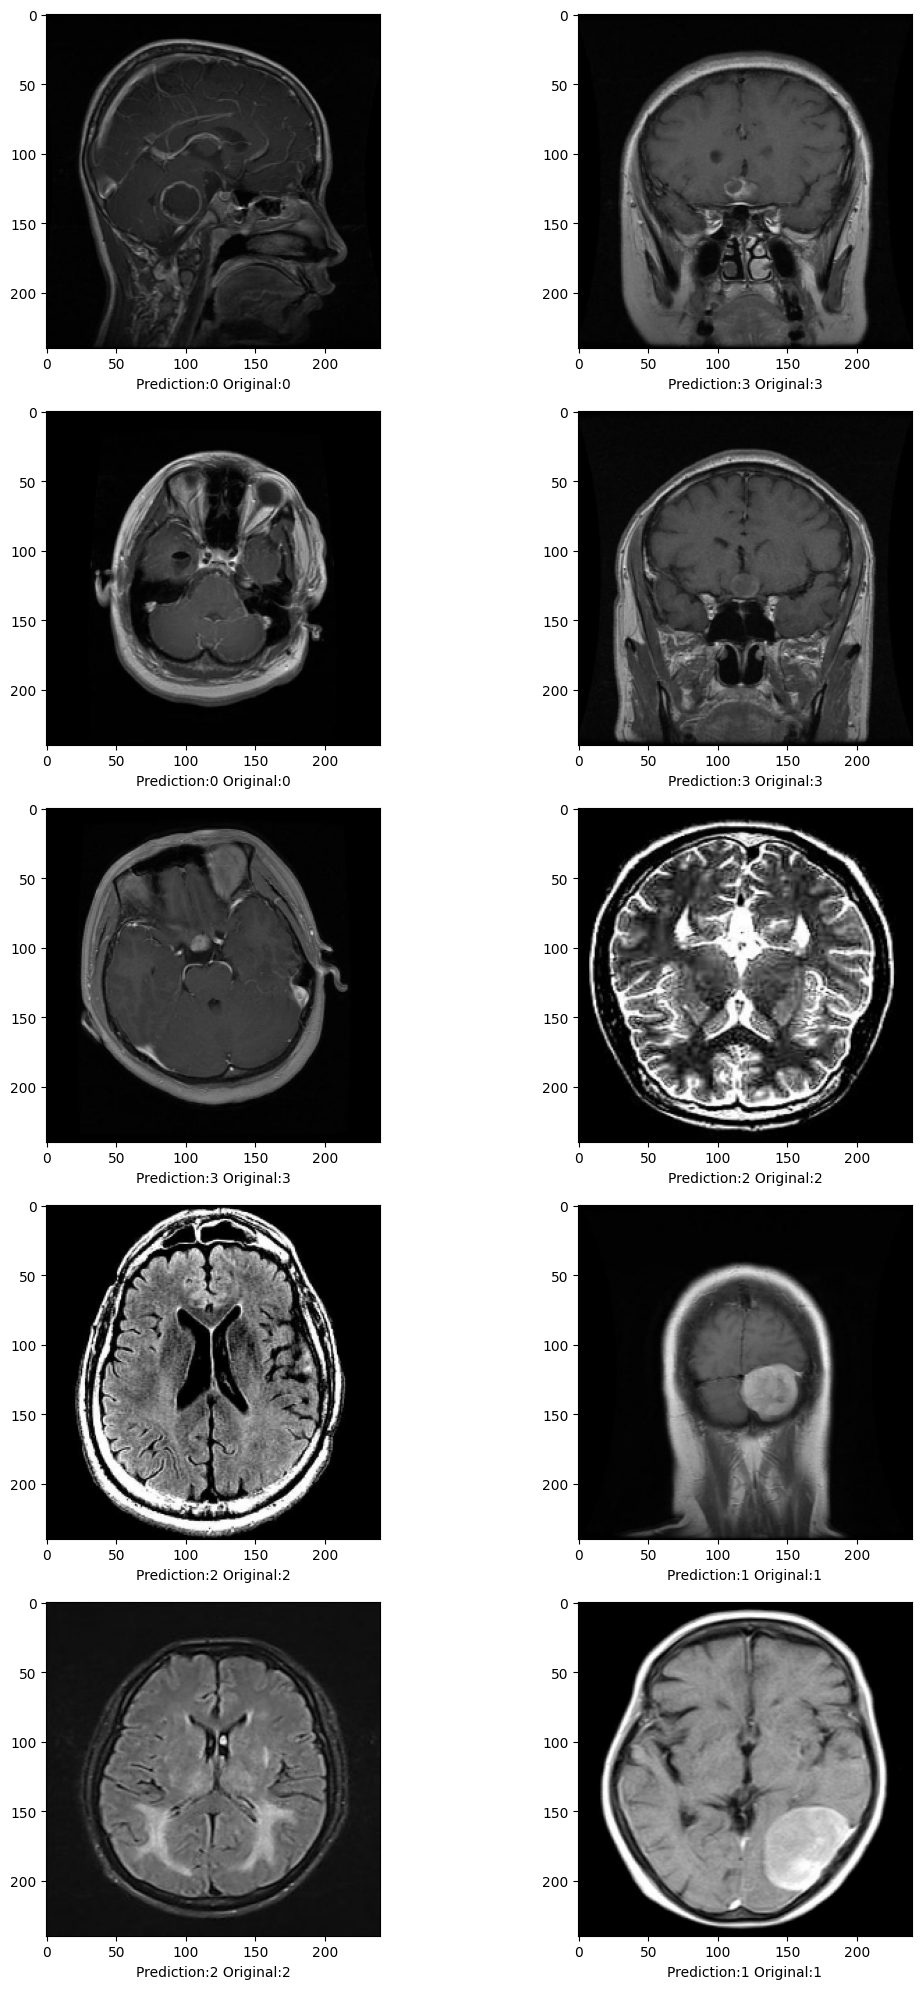

In [ ]:
fig=plt.figure(figsize=(12,20))

for i in range(10):
    j = random.randint(0,len(images))
    fig.add_subplot(5,2, i+1)
    plt.xlabel("Prediction:" + str(predictions[j]) + " Original:" + str(original[j]))
    plt.imshow(images[j])
fig.tight_layout()
plt.show()